In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Model and Data
- freeze this and make copies for 
- need different things for non-accuracy
- have a script for saving and loading dataframes

- have LF sandbox with visualization/metric for LFs at the bottom after shifting things to utils.py
- percentage of data in each category

In [6]:
model_path = '/lfs/1/mccreery/repos/metal/logs/checkpoints/18-2-2019/COLA_15_11_24/best_model.pth'
# '/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/13-2-2019/RTE_22_52_53/best_model.pth'
task_name = 'COLA' #'RTE'
split = 'dev'

#Load model and data
model,dl = load_data_and_model(model_path,task_name,split)

#Create DataFrame of Raw Data, Predictions, and Labels
print('creating dataframe')
df_error = create_dataframe(model_path,task_name,model,dl)
print('created dataframe')
df_error.head()

#Save (and reload) DataFrame
csv_path = '/'.join(model_path.split('/')[0:-1])
filepath = f'{task_name}_{split}_error_analysis.tsv'
save_dataframe(df_error,filepath)
df_error = load_dataframe(filepath)


Loading COLA Dataset



creating dataframe


100%|██████████| 33/33 [00:01<00:00, 32.20it/s]

created dataframe
Saved dataframe to:  COLA_dev_error_analysis.tsv


## Sandbox for Error Analysis

**0. Some basic statistics.**

Confusion Matrix and Performance Metrics

In [7]:
from metal.analysis import confusion_matrix
#TODO: change to use the right function for label space change (0,1) to (1,2)
confusion_matrix( df_error['label']+1.,1*(df_error['score']>0.5)+1., pretty_print=True)
print()

from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(df_error['label']+1., 1*(df_error['score']>0.5)+1., metric, probs=df_error['score'])
    print(f"{metric.capitalize()}: {score:.3f}")

        y=1    y=2   
 l=1    119    22    
 l=2    203    699   

Accuracy: 0.784
Precision: 0.844
Recall: 0.370
F1: 0.514


Plotting Predictions and Predicted Probabilistic Label Distribution

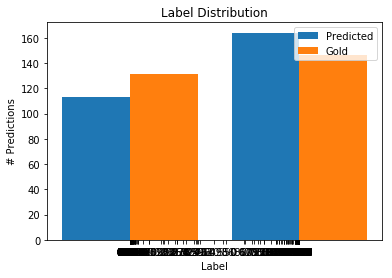

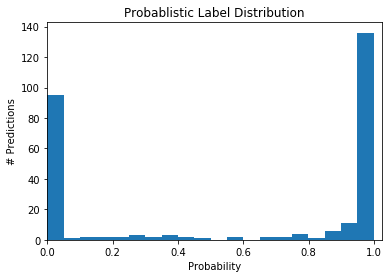

In [4]:
from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
    )

plot_predictions_histogram(df_error['score'], df_error['label'], title="Label Distribution")
plot_probabilities_histogram(df_error['score'], title="Probablistic Label Distribution")

**1. We want to look at examples that are "barely" wrong and "barely" right since we have hope for boosts here.**

In [5]:
print("\033[1mBARELY WRONG\033[0;0m")
for i in range(3):
    print_barely_pred(df_error,is_incorrect=True,thresh=0.2)
    
print("\033[1mBARELY RIGHT\033[0;0m")
for i in range(3):
    print_barely_pred(df_error,is_incorrect=False,thresh=0.15)

BARELY WRONG
ID:  2
sentence1: 	 cairo is now home to some 15 million people - a bu ##rgeon ##ing population that produces approximately 10 , 000 tonnes of rubbish per day , putting an enormous strain on public services . in the past 10 years , the government has tried hard to encourage private investment in the refuse sector , but some estimate 4 , 000 tonnes of waste is left behind every day , fest ##ering in the heat as it waits for someone to clear it up . it is often the people in the poor ##est neighbourhoods that are worst affected . but in some areas they are fighting back . in shu ##bra , one of the northern districts of the city , the residents have taken to the streets armed with dust ##pan ##s and brushes to clean up public areas which have been used as public dump ##s . 
sentence2: 	 15 million tonnes of rubbish are produced daily in cairo . 
score: 	0.9369
label: 	0

ID:  16
sentence1: 	 mice given a substance found in red wine lived longer despite a fatty diet , a study 

**2. We also want to look at examples we got completely wrong since that could point to a systematic bias in the data/model. It could also help us find examples in the dataset that are mislabeled by human annotators**

In [6]:
print("\033[1mVERY WRONG\033[0;0m")
for i in range(3):
    print_very_wrong_pred(df_error)

VERY WRONG
ID:  167
sentence1: 	 today ' s best estimate of giant panda numbers in the wild is about 1 , 100 individuals living in up to 32 separate populations mostly in china ' s sichuan province , but also in sha ##an ##xi and gan ##su provinces . 
sentence2: 	 there are 32 panda ##s in the wild in china . 
score: 	0.9995
label: 	0

ID:  264
sentence1: 	 hurricane katrina petroleum - supply outlook improved somewhat , yesterday , as u . s . and european governments agreed to release 2 million barrels a day , of oil and refined products , from their reserves . 
sentence2: 	 60 million barrels of oil and gasoline will be available to the marketplace . 
score: 	0.9974
label: 	0

ID:  13
sentence1: 	 a jury is slated to decide for the first time whether jack ke ##vor ##kian , famed as " dr . death , " has violated michigan ' s assisted - suicide ban , while the state continues to gr ##apple with the issue of what to allow when the ill want to end their pain by ending their lives . 
sent

**3. To find systematic errors, we can also look for correlations between certain features and the incorrectness a la Socratic**


We can make this way more sophisticated by perhaps using embeddings instead of this simple [BoW featurization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer).

In [7]:
print("\033[1mSYSTEMATIC EXAMPLES\033[0;0m")
for i in range(3):
    print_systematic_wrong(df_error)

SYSTEMATIC EXAMPLES
10 000
holy field
legal ization
meet president
award winning

sentence1: 	 romano pro ##di will meet the us president george bush in his capacity as president of the european commission . 
sentence2: 	 romani pro ##di is the us president . 
score: 	0.9841
label: 	0



/dfs/scratch0/vschen/venv-mmtl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10 000
holy field
legal ization
meet president
award winning

sentence1: 	 both sides of this argument are presented in this paper , but it is the attempt of this paper to emphasize that the legal ##ization of drugs would be destructive to our society . 
sentence2: 	 drug legal ##ization has benefits . 
score: 	0.5684
label: 	0

10 000
holy field
legal ization
meet president
new government

sentence1: 	 cairo is now home to some 15 million people - a bu ##rgeon ##ing population that produces approximately 10 , 000 tonnes of rubbish per day , putting an enormous strain on public services . in the past 10 years , the government has tried hard to encourage private investment in the refuse sector , but some estimate 4 , 000 tonnes of waste is left behind every day , fest ##ering in the heat as it waits for someone to clear it up . it is often the people in the poor ##est neighbourhoods that are worst affected . but in some areas they are fighting back . in shu ##bra , one of the northern d

## Designing Labeling Functions

**1. Number Based LF**

Our model tends to fail when there are numbers involved in the two sentences. We can look for the same number being repeated in both sentences as an LF

In [8]:
def LF_number(idx):
    sentence1_nums = [int(s) for s in df_error['sentence1'][idx].split() if s.isdigit()]
    sentence2_nums = [int(s) for s in df_error['sentence2'][idx].split() if s.isdigit()]
    common_nums = len(set(sentence1_nums).intersection(set(sentence2_nums)))
    
    if (sentence1_nums == []) or (sentence2_nums == []):
        return 0
    
    if common_nums > 0:
        return 2
    else:
        return 1

In [9]:
print_row(df_error.iloc[70])
print("LF_label: ", LF_number(70)-1)

print()
print()
print_row(df_error.iloc[254])
print("LF_label: ", LF_number(254)-1)

sentence1: 	 about 33 . 5 million people live in this massive con ##ur ##bation . i would guess that 95 % of the 5 , 000 officially foreign - capital firms in japan are based in tokyo . 
sentence2: 	 about 33 . 5 mi ##ili ##on people live in tokyo . 
score: 	0.0013
label: 	1

LF_label:  1


sentence1: 	 monica meadows , a 22 - year - old model from atlanta , was shot in the shoulder on a subway car in new york city . 
sentence2: 	 monica meadows , 23 , was shot in shoulder while riding a subway car in new york city 
score: 	0.9993
label: 	0

LF_label:  0


**2. Edit Distance Based LF**

Our model tends to vote entailment when one sentence is long and the other is short. We can focus on this slice and flip the labelt o vote no entailment even when the number of words is the same.

In [10]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

from collections import Counter
def common_words(s1,s2):
    s1_set = set(Counter(s1.split()))
    s2_set = set(Counter(s2.split()))
    return len(s1_set.intersection(s2_set))/float(min(len(s1_set),len(s2_set)))

In [11]:
def LF_words(idx):
    ratio = common_words(df_error['sentence1'][idx], df_error['sentence2'][idx])
    if ratio < 0.3:
        return 2
    if (ratio <= 1.0) and (ratio > 0.4):
        return 1
    else:
        return 0

In [12]:
print_row(df_error.iloc[150])
print("LF_label: ", LF_words(150)-1)

print()
print()
print_row(df_error.iloc[95])
print("LF_label: ", LF_words(95)-1)

sentence1: 	 quebec woman and her mother accused of plotting to kill a four - year - old girl . 
sentence2: 	 quebec woman murdered a four - year - old girl . 
score: 	0.9991
label: 	0

LF_label:  0


sentence1: 	 i asked myself how to understand the ' twilight ' s success . and i have come to the idea that when you really believe in something , sooner or later it will become real . so , i guess this is what happened with robert patti ##nson . last year he was just an unknown actor who ' s biggest role was in a pair of " harry potter " movies . now , not only that twilight is competing with ' harry potter ' , but robert patti ##nson is one of the most famous young actors who sucked $ 37 ##3 . 4 million from global box offices . so the movie about a vampire boy who falls in love with a normal girl , begun a real hysteria . and patti ##nson has a lot to do with it ! . 
sentence2: 	 robert patti ##nson is a vampire . 
score: 	0.9206
label: 	0

LF_label:  0


### Analyze Labeling Functions

In [13]:
L = np.zeros((np.shape(df_error)[0],2))
for i in range(df_error.shape[0]):
    L[i,0] = LF_number(i)
    L[i,1] = LF_words(i)

Labeling Function Summary

In [14]:
from metal.analysis import lf_summary
from scipy.sparse import csr_matrix    

L_sparse = csr_matrix(L)
lf_summary(L_sparse,Y=df_error.label+1)

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1.0, 2.0]",0.158845,0.155235,0.129964,22,22,0.500000
1,"[1.0, 2.0]",0.949458,0.155235,0.129964,115,148,0.437262


In [16]:
incorrect = set(np.where(df_error.is_wrong == True)[0])
LF1_set = set(np.where(L[:,0]-1. == df_error.label)[0])
LF2_set = set(np.where(L[:,1]-1. == df_error.label)[0])

print("Percentage Corrected by LF_num: ", 100.*len(LF1_set.intersection(incorrect))/float(len(incorrect)))
print("Percentage Corrected by LF_words: ", 100.*len(LF2_set.intersection(incorrect))/float(len(incorrect)))

Percentage Corrected by LF_num:  8.88888888888889
Percentage Corrected by LF_words:  61.111111111111114
